In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
df  = pd.read_csv("drive/MyDrive/data/IBM_HistoricalData_20241216.csv")
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Prepare the data
df['Close'] = df['Close'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort the DataFrame by date in ascending order
df = df.sort_index()
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-17,129.9125,2907547,129.9705,130.3674,129.1769
2019-12-18,130.0964,3102353,130.2319,130.6674,129.8451
2019-12-19,130.2416,3866717,130.1448,130.4013,129.8834
2019-12-20,131.2385,7112072,131.3837,132.0419,130.6190
2019-12-23,131.1998,2803168,131.4224,131.7805,130.6674


In [ ]:
df.tail()

,Close,Volume,Open,High,Low
Date,,,,,
2024-12-10,231.72,4769531,228.40,234.390,227.80
2024-12-11,230.12,3872680,232.69,233.000,229.13
2024-12-12,232.26,4515741,230.66,233.890,230.38
2024-12-13,230.82,2757683,232.25,233.775,230.26
2024-12-16,229.33,3610257,230.73,231.030,226.88


In [ ]:
# Create lagged features
num_lag = 2
for lag in range(1, num_lag + 1):  # Using the past num_lag days
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)
    df[f'Open_lag_{lag}'] = df['Open'].shift(lag)
    df[f'High_lag_{lag}'] = df['High'].shift(lag)
    df[f'Low_lag_{lag}'] = df['Low'].shift(lag)

# Drop rows with NaN values
df = df.dropna()

# Create the target variable
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Features and target
features = ['Close', 'Volume', 'Open', 'High', 'Low'] + [
    f'{col}_lag_{lag}' for col in ['Close', 'Volume', 'Open', 'High', 'Low'] for lag in range(1, num_lag + 1)
    ]
X = df[features]
y = df['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
df.head()

<ipython-input-120-b46d7200b869>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Close'] > df['Open']).astype(int)


,Close,Volume,Open,High,Low,Close_lag_1,Volume_lag_1,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_2,Volume_lag_2,Open_lag_2,High_lag_2,Low_lag_2,Target
Date,,,,,,,,,,,,,,,,
2019-12-19,130.2416,3866717,130.1448,130.4013,129.8834,130.0964,3102353.0,130.2319,130.6674,129.8451,129.9125,2907547.0,129.9705,130.3674,129.1769,1
2019-12-20,131.2385,7112072,131.3837,132.0419,130.6190,130.2416,3866717.0,130.1448,130.4013,129.8834,130.0964,3102353.0,130.2319,130.6674,129.8451,0
2019-12-23,131.1998,2803168,131.4224,131.7805,130.6674,131.2385,7112072.0,131.3837,132.0419,130.6190,130.2416,3866717.0,130.1448,130.4013,129.8834,0
2019-12-24,130.6481,1202087,131.2579,131.2675,130.2899,131.1998,2803168.0,131.4224,131.7805,130.6674,131.2385,7112072.0,131.3837,132.0419,130.6190,0
2019-12-26,130.5803,2130706,130.6481,130.9631,130.3287,130.6481,1202087.0,131.2579,131.2675,130.2899,131.1998,2803168.0,131.4224,131.7805,130.6674,0


In [ ]:
# df.to_csv("drive/MyDrive/data/AMD_HistoricalData_20241204_with_lags.csv")

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Predict whether the close will be higher or lower than the open for the next day
today_features = pd.DataFrame([df.iloc[-1][features]], columns=features)
today_features_scaled = scaler.transform(today_features)
next_day_prediction = rf.predict(today_features_scaled)
print(f'Roughly predicted direction for tomorrow\'s trend: {"Up" if next_day_prediction[0] == 1 else "Down"}')


Accuracy: 0.746031746031746
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       114
           1       0.79      0.72      0.76       138

    accuracy                           0.75       252
   macro avg       0.75      0.75      0.75       252
weighted avg       0.75      0.75      0.75       252

Roughly predicted direction for tomorrow's trend: Down


**0 and 1:** These represent the two classes. 0 represents "Lower" and 1 represents "Higher" for the next day's opening price.


**Precision:** This measures the accuracy of the positive predictions. It is the ratio of true positive predictions to the total predicted positives. High precision means that the model has a low false positive rate.

Formula:
Precision = True Positives /
(True Positives
+
False Positives)

**Recall:** This measures the ability of the model to find all the relevant cases (true positives). It is the ratio of true positive predictions to the total actual positives. High recall means that the model has a low false negative rate.

Formula:
Recall
=
True Positives /
(True Positives
+
False Negatives)

**F1-Score:** This is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A high F1-score indicates a good balance between precision and recall.

Formula:
F1-Score
=
2
×
(Precision
×
Recall) /
(Precision
+
Recall)

**Support:** This is the number of actual occurrences of each class in the dataset. It shows how many instances of each class are present in the test set.



**Macro Avg:** This is the average of the precision, recall, and F1-score for each class, without considering the class imbalance. It treats all classes equally.

Formula:
Macro Avg
=
(Precision
0
+
Precision
1) /
2


**Weighted Avg:** This is the average of the precision, recall, and F1-score for each class, weighted by the number of instances in each class. It accounts for class imbalance by giving more weight to the classes with more instances.

Formula:
Weighted Avg
=
(Support
0
×
Precision
0
+
Support
1
×
Precision
1) /
(Support
0
+
Support
1)


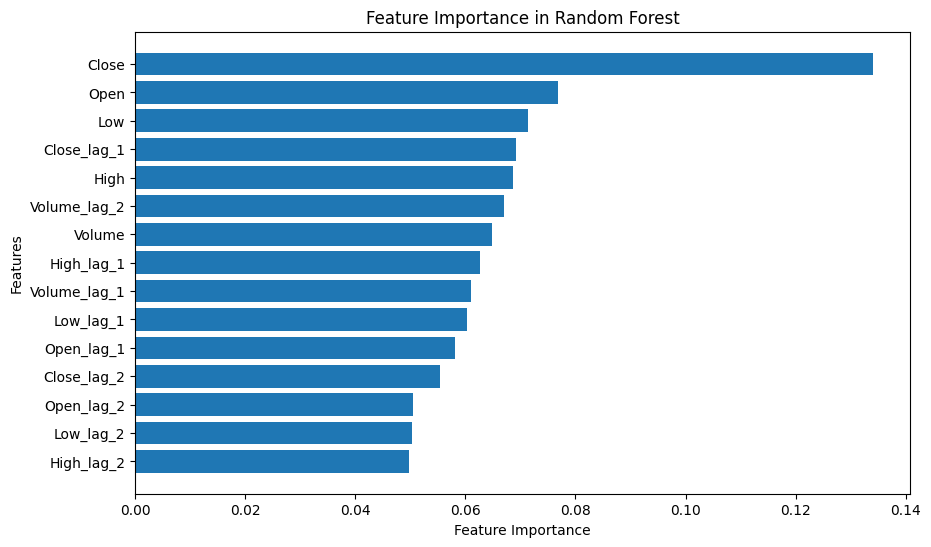

In [ ]:
# Plot feature importance
importance = rf.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using Grid Search for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_gb = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_gb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Predict tomorrow's open price direction
today_features = pd.DataFrame([df.iloc[-1][features]], columns=features)
today_features_scaled = scaler.transform(today_features)
next_day_prediction = rf.predict(today_features_scaled)
print(f'Better predicted direction for tomorrow\'s trend: {"Up" if next_day_prediction[0] == 1 else "Down"}')


Accuracy: 0.8293650793650794
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       114
           1       0.86      0.83      0.84       138

    accuracy                           0.83       252
   macro avg       0.83      0.83      0.83       252
weighted avg       0.83      0.83      0.83       252

Better predicted direction for tomorrow's trend: Down
